# Imports, constants and functions

In [1]:
import os
import nrrd
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import radiomics as pr
import SimpleITK as sitk
import matplotlib.pyplot as plt
from radiomics import featureextractor
from sklearn.linear_model import lasso_path
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Constantes
INPUT_PATH = 'inputs'
IMAGES_PATH = 'images'
OUTPUT_PATH = 'outputs'

columns_file_text = f'{OUTPUT_PATH}/columnas_df_features.txt'

In [3]:
def transform_dataframe(df):
    """
    Transforma un DataFrame con celdas de diferentes clases a numeros o strings.
    
    Para columnas que contienen listas o tuplas:
    - Si la lista o tupla tiene un único elemento, convierte el valor en un número o string según corresponda.
    - Si la lista o tupla tiene múltiples elementos, expande la columna en varias columnas, 
      una por cada elemento de la lista o tupla. Las nuevas columnas se nombran usando el nombre 
      original seguido por un sufijo `_1`, `_2`, etc.

    Para columnas que contienen diccionarios:
    - Cada clave del diccionario se convierte en una nueva columna.
    - Si un valor del diccionario es un array/lista o tupla:
        - Si tiene un único elemento, se convierte en un valor único.
        - Si tiene múltiples elementos, genera columnas adicionales con sufijos `_1`, `_2`, etc.
    - Las nuevas columnas se nombran usando el nombre original seguido por `_{key}` y, si es necesario, 
      un sufijo adicional para los arrays o tuplas.
    - Elimina la columna original una vez procesada.

    Args:
        df (pd.DataFrame): DataFrame original.
    Returns:
        df (pd.DataFrame): DataFrame transformado.
    """
    # Crear una copia para no modificar el original
    transformed_df = df.copy()

    # Iterar sobre las columnas
    for col in transformed_df.columns:
        # Identificar las celdas que son listas, tuplas o arrays
        if transformed_df[col].apply(lambda x: isinstance(x, (list, tuple))).any():
            # Expandir los valores si hay listas/tuplas con más de un elemento
            expanded = transformed_df[col].apply(lambda x: list(x) if isinstance(x, (list, tuple)) else [x])
            
            # Verificar la longitud máxima de las listas/tuplas
            max_len = expanded.apply(len).max()
            
            if max_len > 1:
                # Crear nuevas columnas para listas/tuplas con múltiples elementos
                for i in range(max_len):
                    transformed_df[f"{col}_{i+1}"] = expanded.apply(lambda x: x[i] if i < len(x) else None)
                
                # Eliminar la columna original
                transformed_df.drop(columns=[col], inplace=True)
            else:
                # Convertir listas/tuplas con un único elemento en valores (número o string)
                transformed_df[col] = expanded.apply(lambda x: x[0] if len(x) == 1 else x)
        
        # Identificar las celdas que son diccionarios
        elif transformed_df[col].apply(lambda x: isinstance(x, dict)).any():
            # Expandir las claves del diccionario en nuevas columnas
            dict_expansion = transformed_df[col].apply(lambda x: x if isinstance(x, dict) else {})
            keys = set(k for d in dict_expansion for k in d.keys())
            
            for key in keys:
                # Extraer los valores de la clave específica
                key_values = dict_expansion.apply(lambda x: x.get(key, None))
                
                # Si los valores son arrays, listas o tuplas, manejarlos como tal
                if key_values.apply(lambda x: isinstance(x, (list, tuple))).any():
                    # Expandir los arrays/tuplas en columnas adicionales
                    expanded = key_values.apply(lambda x: list(x) if isinstance(x, (list, tuple)) else [x])
                    max_len = expanded.apply(len).max()
                    
                    for i in range(max_len):
                        transformed_df[f"{col}_{key}_{i+1}"] = expanded.apply(lambda x: x[i] if i < len(x) else None)
                else:
                    # Si no son listas/tuplas, mantener el valor tal cual
                    transformed_df[f"{col}_{key}"] = key_values
            
            # Eliminar la columna original
            transformed_df.drop(columns=[col], inplace=True)

    return transformed_df

In [4]:
def same_sizes(image1, image2):
    """
    Comprueba que la imagen 1 y la imagen 1 tienen las mismas dimensiones.
    Args:
        image1 (SimpleITK.Image): Imagen 1.
        image2 (SimpleITK.Image): Imagen 2.
    Returns:
        boolean: Si el tamaño coincide
    """
    return image1.GetSize() == image2.GetSize()

In [5]:
def extract_features(image_file_path, mask_file_path):
    """
    Extrae características radiómicas de una imagen y su máscara utilizando PyRadiomics.
    Args:
        image_file_path (str): Ruta al archivo NRRD que contiene la imagen a analizar.
        mask_file_path (str): Ruta al archivo NRRD que contiene la máscara asociada a la imagen.
    Returns:
        features (dict): Características radiómicas extraídas.
    Extra:
        Comprueba que el tamaño de las imagenes sea compatible.
    """
    # Cargar la imagen desde el archivo NRRD
    image_data, _ = nrrd.read(image_file_path)
    image = sitk.GetImageFromArray(image_data)
    
    # Cargar la máscara desde el archivo NRRD
    mask_data, _ = nrrd.read(mask_file_path)
    mask = sitk.GetImageFromArray(mask_data)
    
    # Crear un extractor de características de PyRadiomics
    if same_sizes(image, mask):
        extractor = featureextractor.RadiomicsFeatureExtractor()
    else:
        print(f'[ERROR] Sizes are not the same for {image_file_path} and {mask_file_path}')
    
    # Extraer las características radiómicas
    features = extractor.execute(image, mask)
    
    return features

In [6]:
def convert_columns_to_numeric(df):
    """
    Intenta convertir todas las columnas de un DataFrame a valores numéricos, 
    incluyendo la transformación de booleanos a numéricos.
    
    Args:
        df (pd.DataFrame): DataFrame original.
    Returns:
        df (pd.DataFrame): DataFrame transformado.
    """
    # Crear una copia del DataFrame para no modificar el original
    numeric_df = df.copy()
    
    for col in numeric_df.columns:
        try:
            # Convertir booleanos a numéricos explícitamente
            if numeric_df[col].dtype == 'bool':
                numeric_df[col] = numeric_df[col].astype(int)
            
            # Intentar convertir la columna a valores numéricos
            numeric_df[col] = pd.to_numeric(numeric_df[col], errors='raise')
        except Exception as e:
            # Imprimir un mensaje de error y eliminar la columna si falla
            print(f'[ERROR] al convertir la columna {col} a número. {e}')
            numeric_df.drop(columns=[col], inplace=True)
    
    return numeric_df

In [58]:
def plot_correlation_matrix(df):
    """
    Genera una matriz de correlación con un mapa de calor.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    df = df.loc[:, (df != df.iloc[0]).any()]
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Parte superior (cambiar a np.tril para inferior)

    print('Be aware that columns with constant values will not be plot.')
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask)
    plt.title("Matriz de Correlación")
    plt.savefig(f'{IMAGES_PATH}/correlation_matrix.png')
    plt.show()

In [8]:
def plot_lasso_path(X, y):
    """
    Genera un gráfico del camino de Lasso para analizar la importancia de las variables.
    
    Args:
        X (array-like): Variables independientes.
        y (array-like): Variable dependiente.
    """
    alphas, coefs, _ = lasso_path(X, y)
    plt.figure(figsize=(10, 6))
    for coef in coefs:
        plt.plot(-np.log10(alphas), coef)
    plt.xlabel("-Log10(Alpha)")
    plt.ylabel("Coeficientes")
    plt.title("Camino de Lasso (Lasso Path)")
    plt.savefig(f'{IMAGES_PATH}/lasso_path.png')
    plt.show()

In [9]:
def plot_variable_distribution(df):
    """
    Genera gráficos de distribución para todas las columnas numéricas.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns
    for column in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True, bins=30)
        plt.title(f"Distribución de {column}")
        plt.xlabel(column)
        plt.ylabel("Frecuencia")
        plt.show()

In [10]:
def detect_missing_values(df):
    """
    Genera un reporte visual y tabular de valores faltantes.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_report = pd.DataFrame({
        'Valores Faltantes': missing_values,
        'Porcentaje (%)': missing_percentage
    }).sort_values(by='Valores Faltantes', ascending=False)
    print(missing_report)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
    plt.title("Mapa de Valores Faltantes")
    plt.savefig(f'{IMAGES_PATH}/missing_values.png')
    plt.show()

In [11]:
def plot_feature_importance(X, y, feature_names):
    """
    Genera un gráfico de importancia de características usando un modelo de Random Forest.
    
    Args:
        X (array-like): Variables independientes.
        y (array-like): Variable dependiente.
        feature_names (list): Nombres de las características.
    """
    model = RandomForestRegressor(random_state=0)
    model.fit(X, y)
    importance = model.feature_importances_

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance)
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de las Características")
    plt.savefig(f'{IMAGES_PATH}/feature_importance_RF.png')
    plt.show()

In [12]:
def plot_outliers(df):
    """
    Genera boxplots para identificar outliers en las columnas numéricas.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns
    for column in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column])
        plt.title(f"Outliers en {column}")
        plt.show()

In [13]:
def target_correlation_analysis(df, target):
    """
    Analiza la correlación entre las variables independientes y la variable objetivo.
    
    Args:
        df (DataFrame): DataFrame con los datos.
        target (str): Nombre de la columna objetivo.
    """
    correlation = df.corr()[target].sort_values(ascending=False)
    print(f'Correlación con la variable objetivo:{correlation}')

In [14]:
def calculate_vif(X):
    """
    Calcula el Factor de Inflación de la Varianza (VIF) para detectar multicolinealidad.
    
    Args:
        X (DataFrame): Variables independientes.
    """
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

In [15]:
def filter_columns_by_file(df, file_path):
    """
    Filtra las columnas del dataframe según un archivo con nombres de columnas
    seguidos de "OK" o "NO". Las columnas con "NO" se eliminan.
    """
    columns_to_keep = []

    with open(file_path, "r") as f:
        for line in f:
            column_info = line.strip().split()
            if len(column_info) == 2:  # Asegurarse de que hay un nombre y un estado
                column_name, status = column_info
                if status == "OK":
                    columns_to_keep.append(column_name)

    df_clean = df.copy()
    return df_clean[columns_to_keep]

# Load data

In [16]:
# Para cambiar los nombres de los ficheros series, ejecutar en terminal en la carpeta de inputs:
# for file in series*.nrrd; do mv "$file" "${file/series/serie}"; done

In [17]:
df_features = pd.DataFrame()

for num in range(1,20):
    for cancer in ['oc', 'ccr']:
        nrrd_path = os.path.join(INPUT_PATH, 'serie'+str(num)+cancer+'.nrrd')
        mask_path = os.path.join(INPUT_PATH, cancer+str(num)+'.nrrd')
        if os.path.exists(nrrd_path) and os.path.exists(mask_path):
            features_image = extract_features(nrrd_path, mask_path)
            features_image['Cancer'] = mask_path.startswith('ccr')
            df_features = pd.concat([df_features, pd.DataFrame([features_image])], ignore_index=True)
        else:
            print(f'ERROR: No such file for {nrrd_path} or {mask_path}')

ERROR: No such file for inputs/serie1oc.nrrd or inputs/oc1.nrrd
ERROR: No such file for inputs/serie1ccr.nrrd or inputs/ccr1.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie2ccr.nrrd or inputs/ccr2.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie3ccr.nrrd or inputs/ccr3.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie4ccr.nrrd or inputs/ccr4.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie5ccr.nrrd or inputs/ccr5.nrrd
ERROR: No such file for inputs/serie6oc.nrrd or inputs/oc6.nrrd
ERROR: No such file for inputs/serie6ccr.nrrd or inputs/ccr6.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie7ccr.nrrd or inputs/ccr7.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie8ccr.nrrd or inputs/ccr8.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie9ccr.nrrd or inputs/ccr9.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie10ccr.nrrd or inputs/ccr10.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie11ccr.nrrd or inputs/ccr11.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie12ccr.nrrd or inputs/ccr12.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie13ccr.nrrd or inputs/ccr13.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie14ccr.nrrd or inputs/ccr14.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie15ccr.nrrd or inputs/ccr15.nrrd


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


ERROR: No such file for inputs/serie16ccr.nrrd or inputs/ccr16.nrrd
ERROR: No such file for inputs/serie17oc.nrrd or inputs/oc17.nrrd
ERROR: No such file for inputs/serie17ccr.nrrd or inputs/ccr17.nrrd
ERROR: No such file for inputs/serie18oc.nrrd or inputs/oc18.nrrd
ERROR: No such file for inputs/serie18ccr.nrrd or inputs/ccr18.nrrd
ERROR: No such file for inputs/serie19oc.nrrd or inputs/oc19.nrrd
ERROR: No such file for inputs/serie19ccr.nrrd or inputs/ccr19.nrrd


In [18]:
df_features.shape

(14, 223)

In [19]:
df_features.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_ngtdm 2_Coarseness,original_ngtdm 2_Complexity,original_ngtdm 2_Contrast,original_ngtdm 2_Strength,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer
0,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},22e18047512aa52054d6739e261bd24e91937a10,3D,"(1.0, 1.0, 1.0)",...,0.003241768060462912,12.774190506780394,0.02383802375880444,0.08217928137111477,5.7200435491548625,0.003241768060462912,12.774190506780394,0.02383802375880444,0.08217928137111477,False
1,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},936b1d9f5056d5a32ebf6c71eaaed2b35225e210,3D,"(1.0, 1.0, 1.0)",...,0.0004677857006774018,16.78962966528958,0.023227241355876355,0.01701672735011439,32.55287967064815,0.0004677857006774018,16.78962966528958,0.023227241355876355,0.01701672735011439,False
2,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},c9bc35ba35cba278e2c3330b7ee7c2aae51bab1b,3D,"(1.0, 1.0, 1.0)",...,0.0031384903950389016,8.219150136266098,0.026940906812980937,0.03572011796585295,13.090148638950009,0.0031384903950389016,8.219150136266098,0.026940906812980937,0.03572011796585295,False
3,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},ad99bfbbdcfb786e94824ac079be68e905f5db2a,3D,"(1.0, 1.0, 1.0)",...,0.0032715088251334167,29.058727104243093,0.018040953659193032,0.17153087551510546,2.961864559870983,0.0032715088251334167,29.058727104243093,0.018040953659193032,0.17153087551510546,False
4,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fa17a959aa9c16301b5a3802f0efcb4a1507fcd7,3D,"(1.0, 1.0, 1.0)",...,0.0008193834471981724,12.417841300737862,0.020371332413605982,0.024642382126863212,19.66226372818894,0.0008193834471981724,12.417841300737862,0.020371332413605982,0.024642382126863212,False


# Clean dataframe

In [20]:
with open(f'{columns_file_text}', "w") as f:
    for column in df_features.columns:
        f.write(column + " OK \n")

In [21]:
df_features.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_ngtdm 2_Coarseness,original_ngtdm 2_Complexity,original_ngtdm 2_Contrast,original_ngtdm 2_Strength,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer
0,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},22e18047512aa52054d6739e261bd24e91937a10,3D,"(1.0, 1.0, 1.0)",...,0.003241768060462912,12.774190506780394,0.02383802375880444,0.08217928137111477,5.7200435491548625,0.003241768060462912,12.774190506780394,0.02383802375880444,0.08217928137111477,False
1,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},936b1d9f5056d5a32ebf6c71eaaed2b35225e210,3D,"(1.0, 1.0, 1.0)",...,0.0004677857006774018,16.78962966528958,0.023227241355876355,0.01701672735011439,32.55287967064815,0.0004677857006774018,16.78962966528958,0.023227241355876355,0.01701672735011439,False
2,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},c9bc35ba35cba278e2c3330b7ee7c2aae51bab1b,3D,"(1.0, 1.0, 1.0)",...,0.0031384903950389016,8.219150136266098,0.026940906812980937,0.03572011796585295,13.090148638950009,0.0031384903950389016,8.219150136266098,0.026940906812980937,0.03572011796585295,False
3,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},ad99bfbbdcfb786e94824ac079be68e905f5db2a,3D,"(1.0, 1.0, 1.0)",...,0.0032715088251334167,29.058727104243093,0.018040953659193032,0.17153087551510546,2.961864559870983,0.0032715088251334167,29.058727104243093,0.018040953659193032,0.17153087551510546,False
4,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fa17a959aa9c16301b5a3802f0efcb4a1507fcd7,3D,"(1.0, 1.0, 1.0)",...,0.0008193834471981724,12.417841300737862,0.020371332413605982,0.024642382126863212,19.66226372818894,0.0008193834471981724,12.417841300737862,0.020371332413605982,0.024642382126863212,False


### Edita el documento de columnas para eliminarlas. Pon "NO" en las que quieras eliminar.

In [22]:
df_clean = filter_columns_by_file(df_features, columns_file_text)

In [23]:
df_clean.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer
0,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},22e18047512aa52054d6739e261bd24e91937a10,3D,"(1.0, 1.0, 1.0)",...,0.09508767897304132,4.82959870333094,0.023817399933840556,32596.597029320987,5.7200435491548625,0.003241768060462912,12.774190506780394,0.02383802375880444,0.08217928137111477,False
1,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},936b1d9f5056d5a32ebf6c71eaaed2b35225e210,3D,"(1.0, 1.0, 1.0)",...,0.032521046100224466,5.822189483775626,0.0081648879239167,592565.6951002259,32.55287967064815,0.0004677857006774018,16.78962966528958,0.023227241355876355,0.01701672735011439,False
2,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},c9bc35ba35cba278e2c3330b7ee7c2aae51bab1b,3D,"(1.0, 1.0, 1.0)",...,0.09821206277129474,4.08628897607083,0.03622540250447227,18330.016765736927,13.090148638950009,0.0031384903950389016,8.219150136266098,0.026940906812980937,0.03572011796585295,False
3,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},ad99bfbbdcfb786e94824ac079be68e905f5db2a,3D,"(1.0, 1.0, 1.0)",...,0.05317379614828019,5.343489180244788,0.03644567858382506,18288.227120181407,2.961864559870983,0.0032715088251334167,29.058727104243093,0.018040953659193032,0.17153087551510546,False
4,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fa17a959aa9c16301b5a3802f0efcb4a1507fcd7,3D,"(1.0, 1.0, 1.0)",...,0.11779399645156308,5.437255681270703,0.02566954736031488,144790.84145555555,19.66226372818894,0.0008193834471981724,12.417841300737862,0.020371332413605982,0.024642382126863212,False


In [24]:
df_clean = transform_dataframe(df_features)

In [25]:
df_clean.shape

(14, 254)

In [26]:
df_clean.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,...,diagnostics_Mask-original_BoundingBox_3,diagnostics_Mask-original_BoundingBox_4,diagnostics_Mask-original_BoundingBox_5,diagnostics_Mask-original_BoundingBox_6,diagnostics_Mask-original_CenterOfMassIndex_1,diagnostics_Mask-original_CenterOfMassIndex_2,diagnostics_Mask-original_CenterOfMassIndex_3,diagnostics_Mask-original_CenterOfMass_1,diagnostics_Mask-original_CenterOfMass_2,diagnostics_Mask-original_CenterOfMass_3
0,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,22e18047512aa52054d6739e261bd24e91937a10,3D,-507.554195,-1024.0,1467.0,...,373,14,23,22,132.583526,273.373139,383.563348,132.583526,273.373139,383.563348
1,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,936b1d9f5056d5a32ebf6c71eaaed2b35225e210,3D,-692.719556,-1024.0,1327.0,...,146,28,49,50,29.821320,312.528485,169.062169,29.821320,312.528485,169.062169
2,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,c9bc35ba35cba278e2c3330b7ee7c2aae51bab1b,3D,-569.965574,-1024.0,2976.0,...,140,11,19,19,209.714222,325.006261,149.017442,209.714222,325.006261,149.017442
3,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,ad99bfbbdcfb786e94824ac079be68e905f5db2a,3D,-599.390038,-1024.0,1302.0,...,369,13,23,23,67.565429,285.120444,380.695245,67.565429,285.120444,380.695245
4,v3.0.1,1.26.2,2.4.0,1.6.0,3.9.13,fa17a959aa9c16301b5a3802f0efcb4a1507fcd7,3D,-663.913123,-1024.0,1420.0,...,159,20,33,35,191.695901,265.530162,176.317618,191.695901,265.530162,176.317618


In [27]:
df_numeric = convert_columns_to_numeric(df_clean)

[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics a número. Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy a número. Unable to parse string "1.26.2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK a número. Unable to parse string "2.4.0" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet a número. Unable to parse string "1.6.0" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python a número. Unable to parse string "3.9.13" at position 0
[ERROR] al convertir la columna diagnostics_Image-original_Hash a número. Unable to parse string "22e18047512aa52054d6739e261bd24e91937a10" at position 0
[ERROR] al convertir la columna diagnostics_Image-original_Dimensionality a número. Unable to parse string "3D" at position 0
[ERROR] al convertir la columna diagnostics_Mask-original_Hash a número. Unable to parse string "140a2b4fcbeb96e53f207531c9db25d08db

In [28]:
df_numeric.shape

(14, 51)

In [29]:
df_numeric.head()

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_MinorAxisLength,...,diagnostics_Mask-original_BoundingBox_3,diagnostics_Mask-original_BoundingBox_4,diagnostics_Mask-original_BoundingBox_5,diagnostics_Mask-original_BoundingBox_6,diagnostics_Mask-original_CenterOfMassIndex_1,diagnostics_Mask-original_CenterOfMassIndex_2,diagnostics_Mask-original_CenterOfMassIndex_3,diagnostics_Mask-original_CenterOfMass_1,diagnostics_Mask-original_CenterOfMass_2,diagnostics_Mask-original_CenterOfMass_3
0,-507.554195,-1024.0,1467.0,3023,1,0.843453,0.553572,11.544899,20.855289,17.590459,...,373,14,23,22,132.583526,273.373139,383.563348,132.583526,273.373139,383.563348
1,-692.719556,-1024.0,1327.0,32701,1,0.919851,0.539323,24.299774,45.056095,41.444885,...,146,28,49,50,29.821320,312.528485,169.062169,29.821320,312.528485,169.062169
2,-569.965574,-1024.0,2976.0,2236,1,0.946245,0.583899,10.407151,17.823540,16.865433,...,140,11,19,19,209.714222,325.006261,149.017442,209.714222,325.006261,149.017442
3,-599.390038,-1024.0,1302.0,2881,1,0.943982,0.494639,10.132162,20.483960,19.336485,...,369,13,23,23,67.565429,285.120444,380.695245,67.565429,285.120444,380.695245
4,-663.913123,-1024.0,1420.0,11687,1,0.896497,0.571290,18.025287,31.551924,28.286212,...,159,20,33,35,191.695901,265.530162,176.317618,191.695901,265.530162,176.317618


In [42]:
print(f'Antes teniamos {df_numeric.shape[0]} columnas')
df_numeric = df_numeric.dropna(axis=1, how='all')
print(f'Ahora tenemos {df_numeric.shape[0]} columnas')

Antes teniamos 14 columnas
Ahora tenemos 14 columnas


# Look dataframe

In [47]:
# Split labels and features
X = df_numeric.drop(columns=['Cancer'])
y = df_numeric['Cancer']
features_names = X.columns

Be aware that columns with constant values will not be plot.


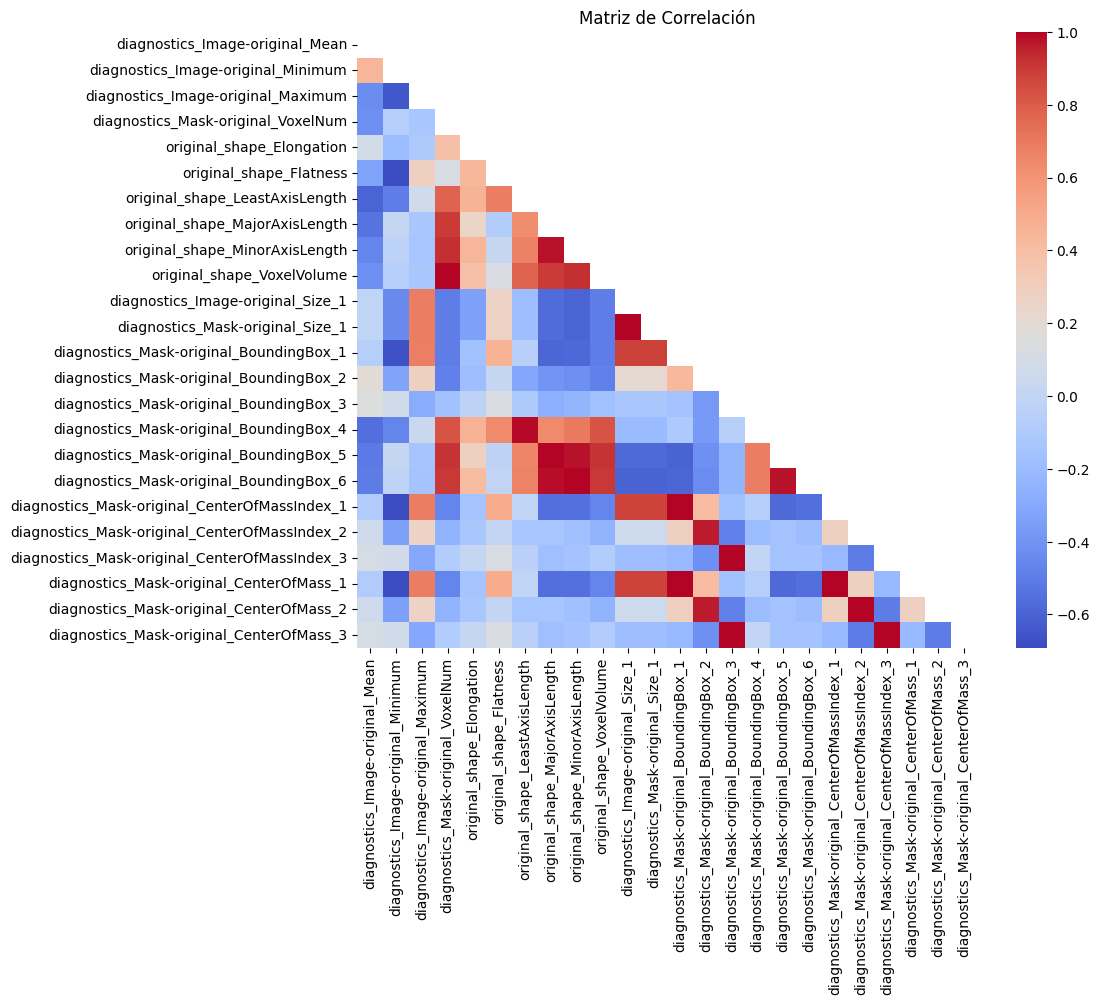

In [59]:
plot_correlation_matrix(X)

/Users/guillermo/Desktop/Code/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


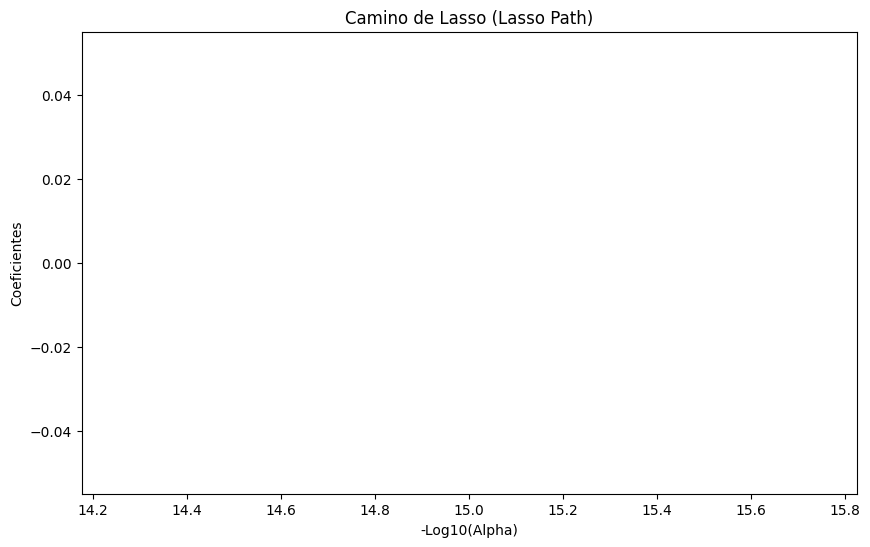

In [60]:
plot_lasso_path(X, y)

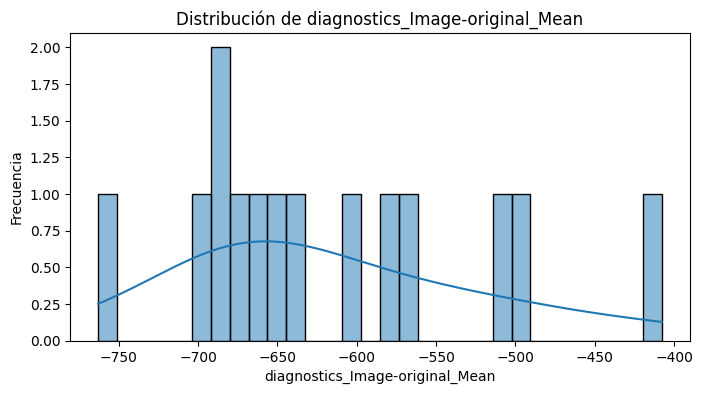

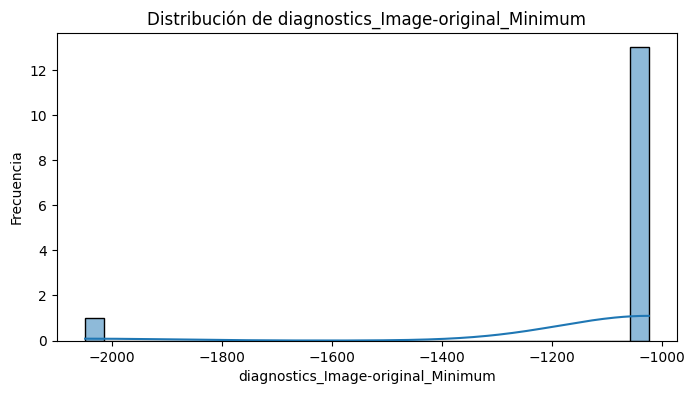

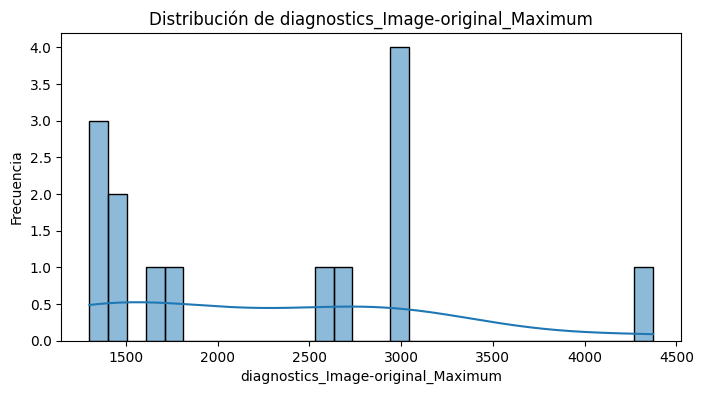

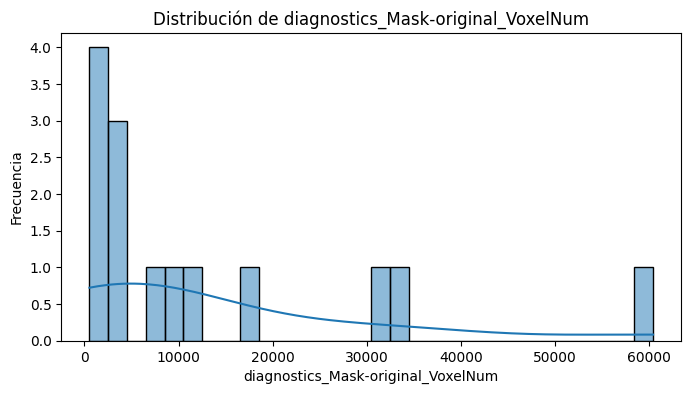

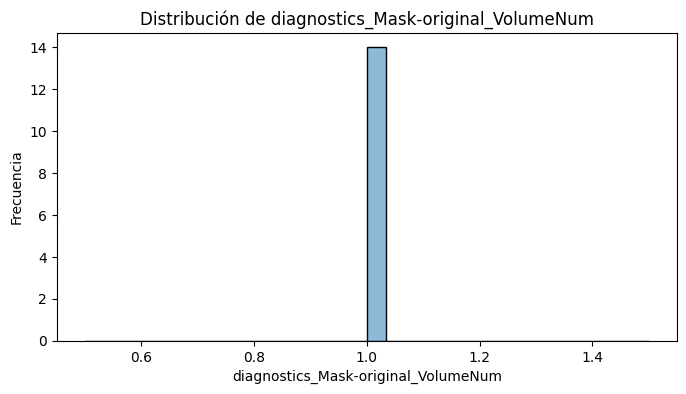

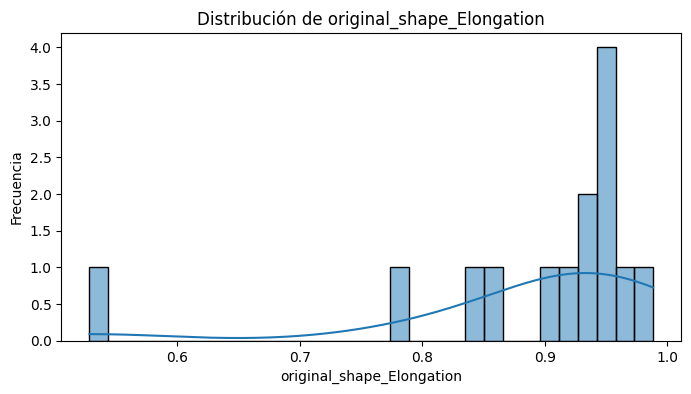

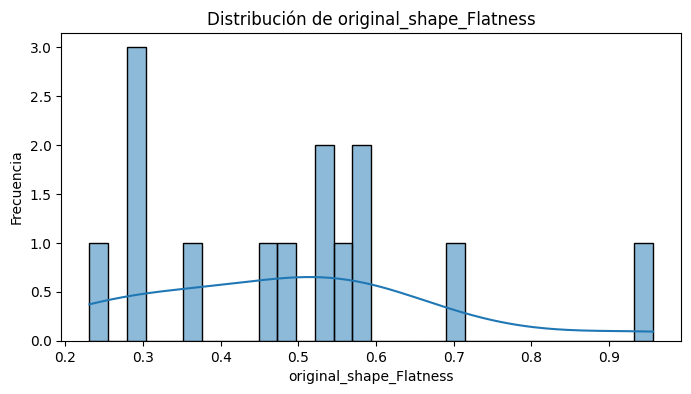

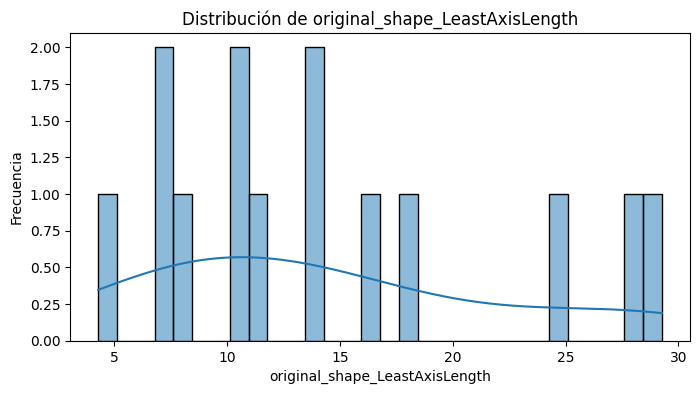

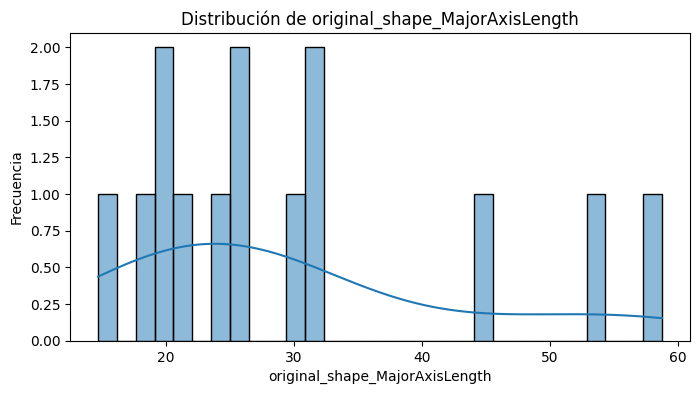

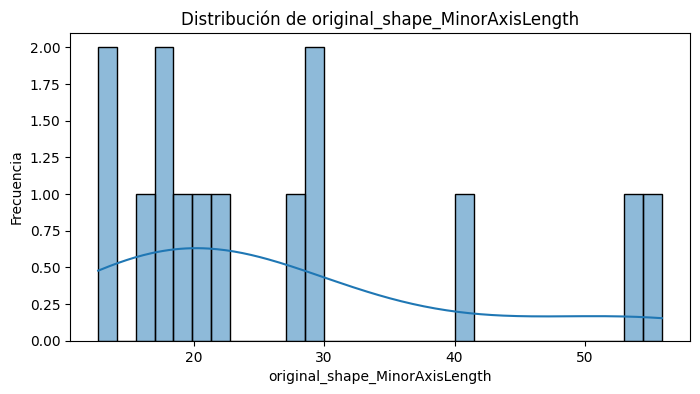

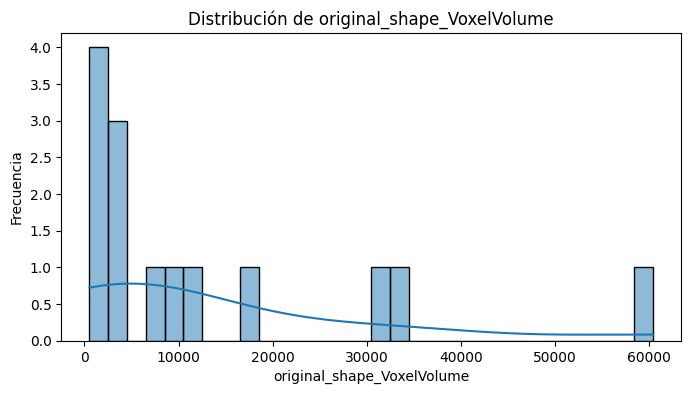

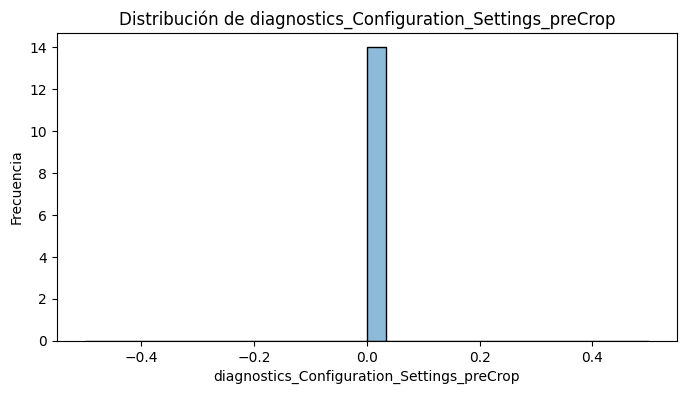

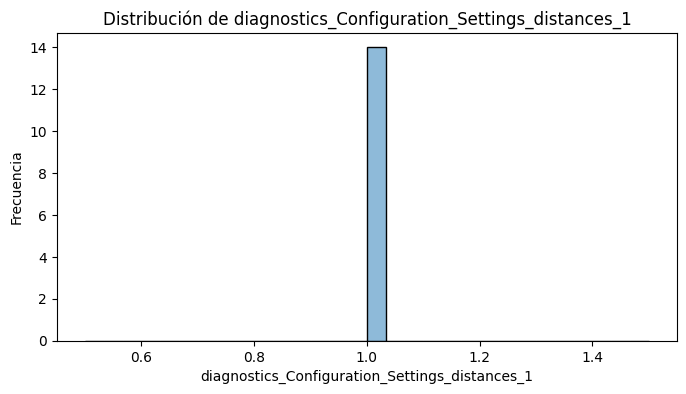

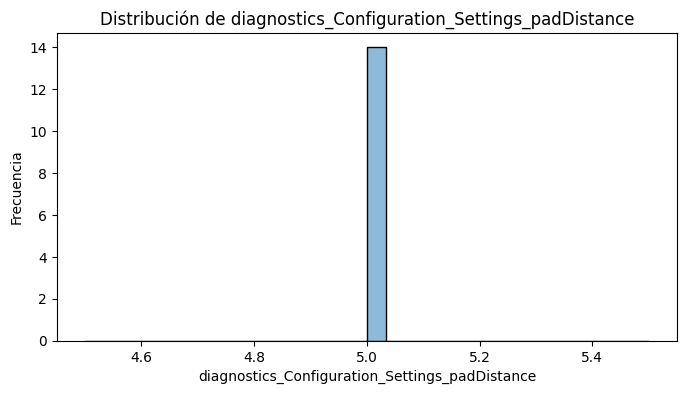

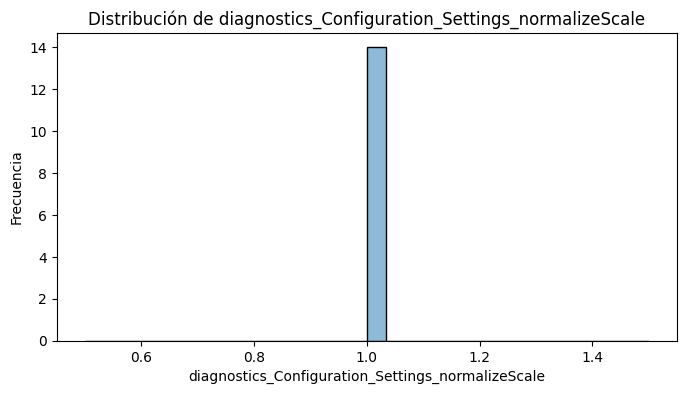

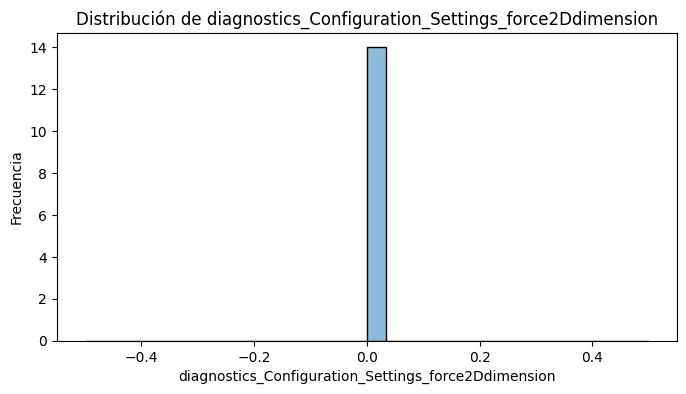

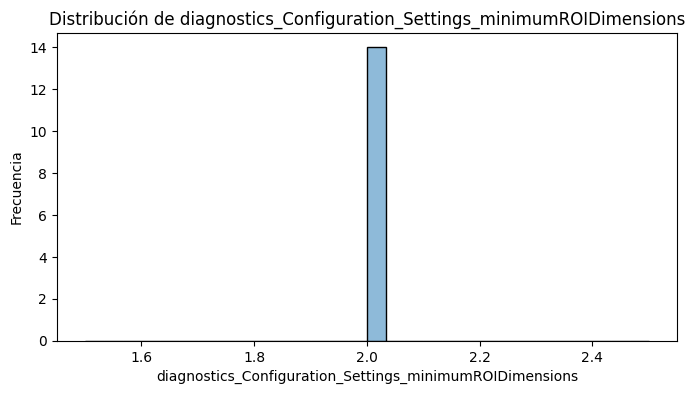

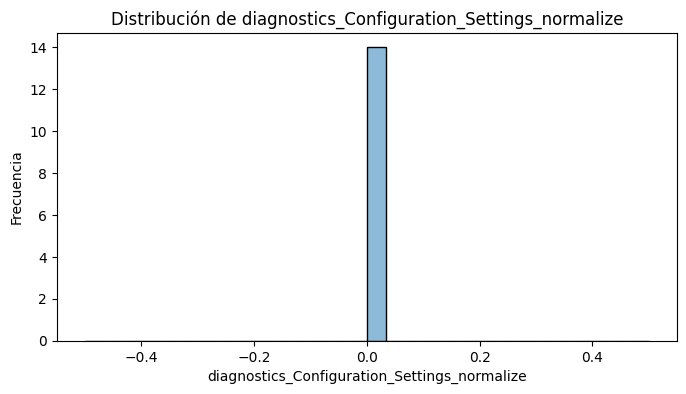

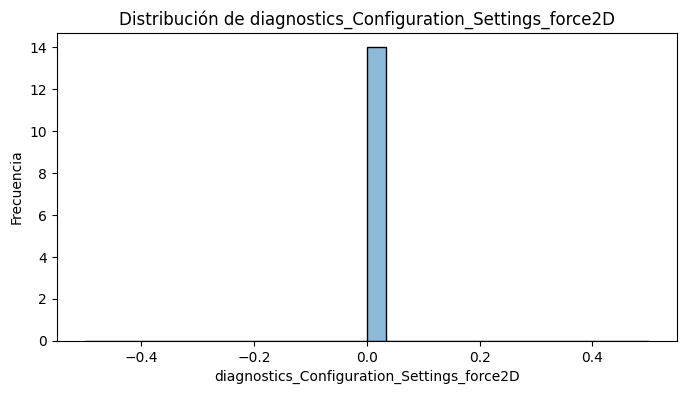

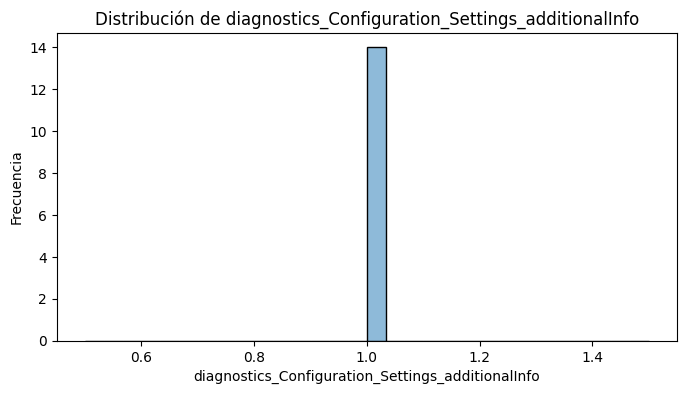

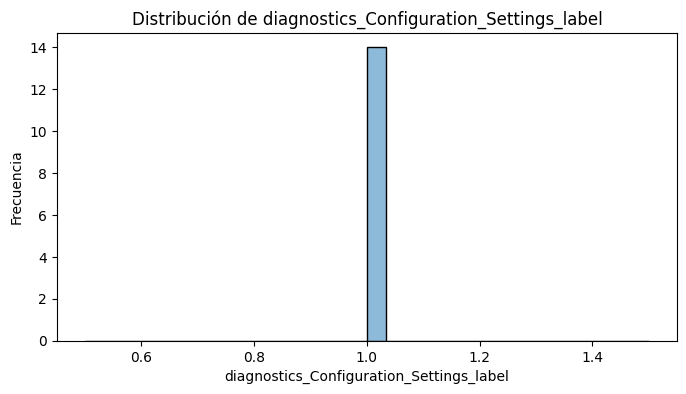

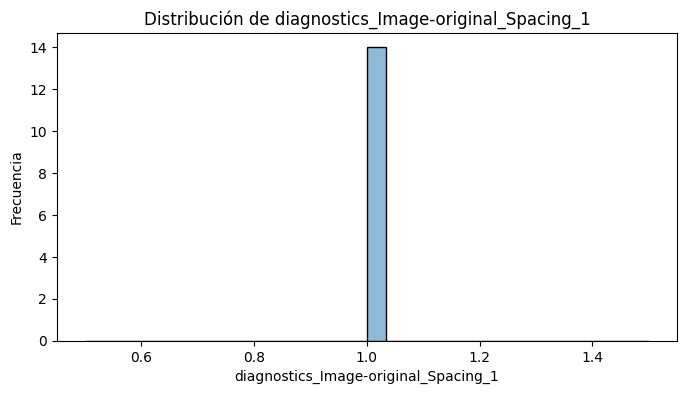

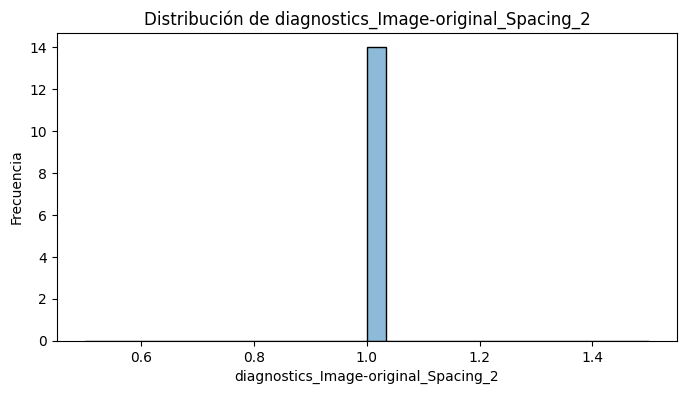

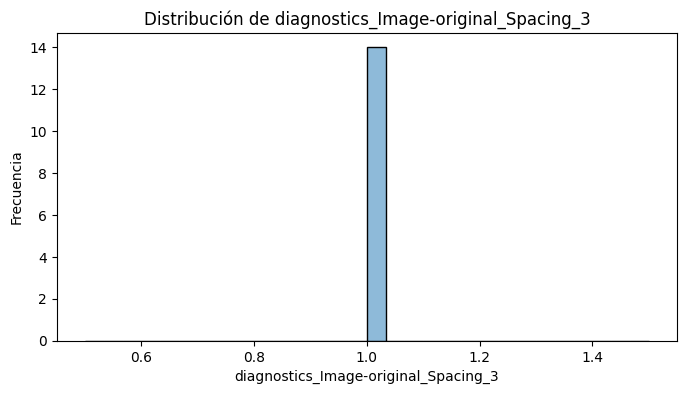

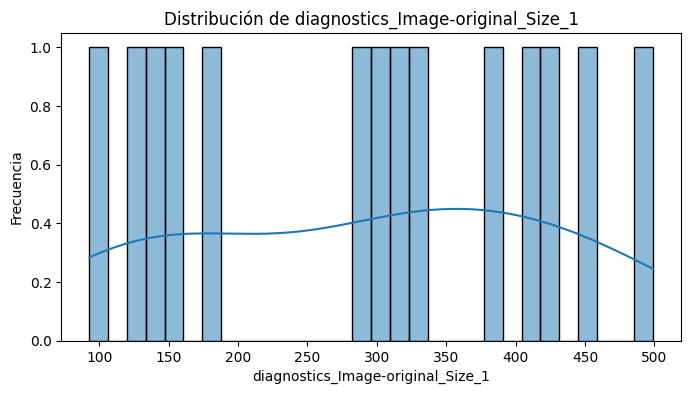

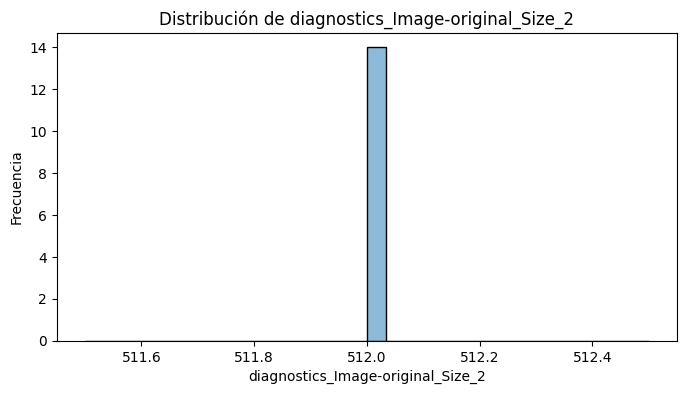

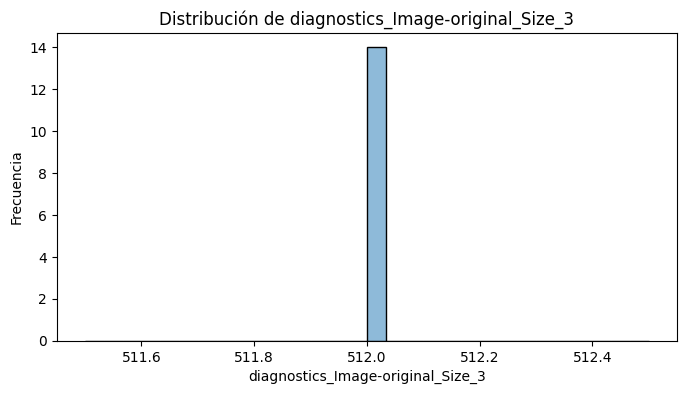

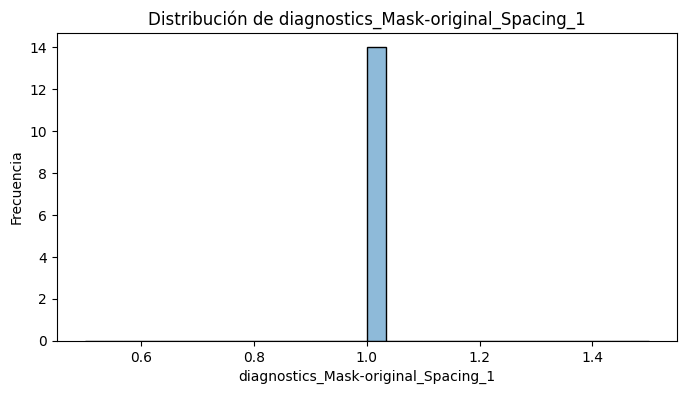

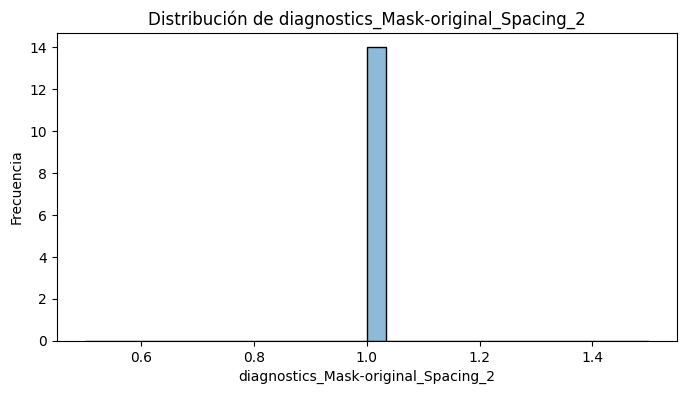

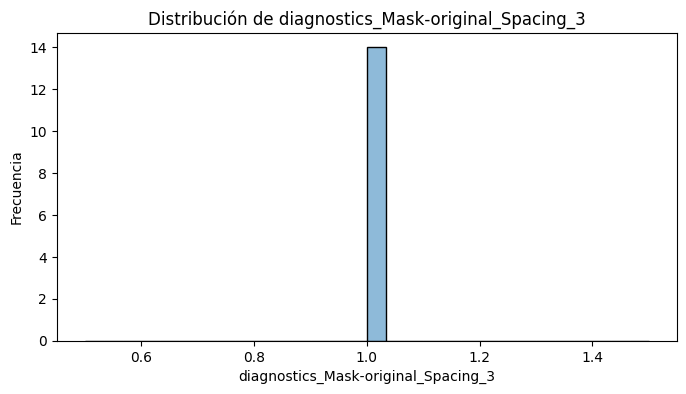

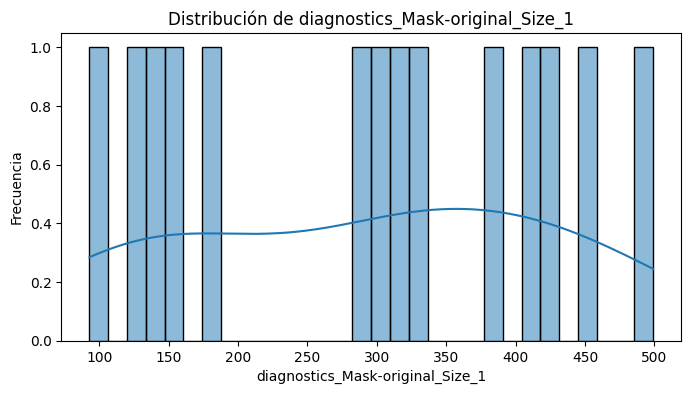

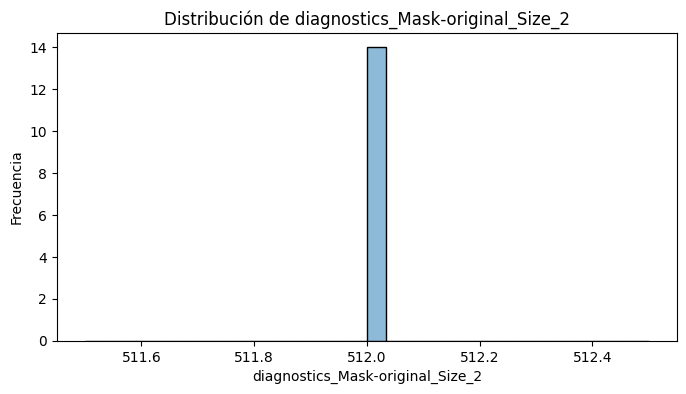

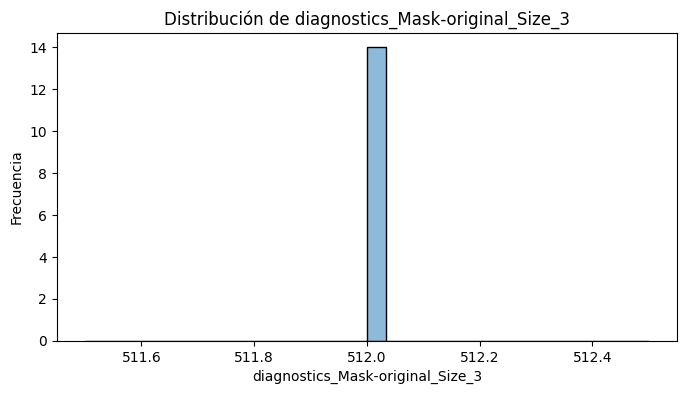

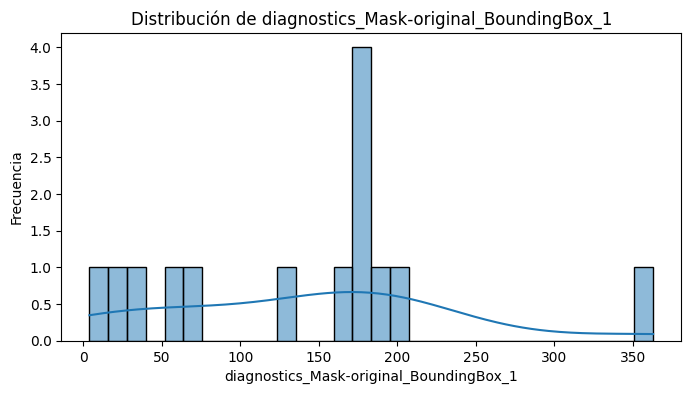

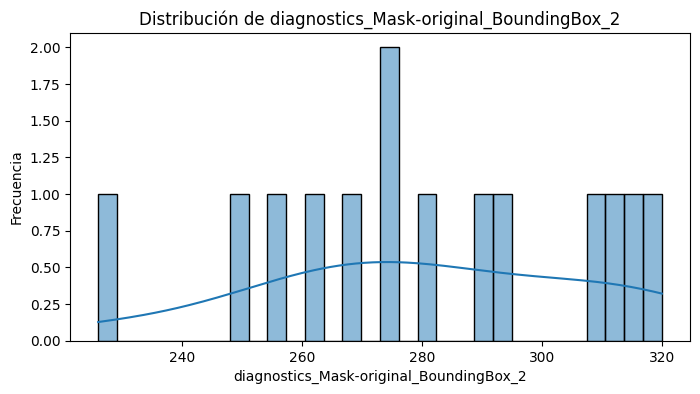

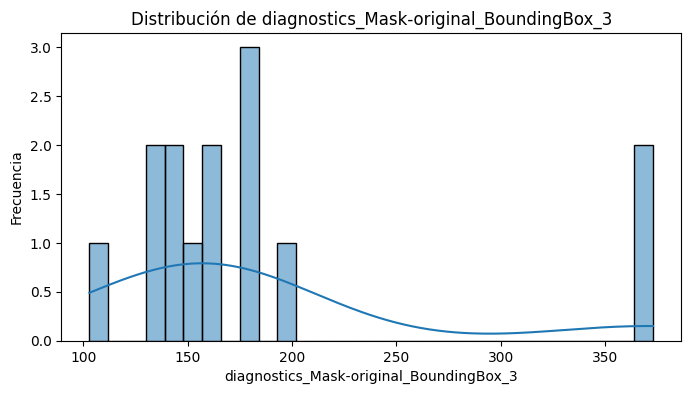

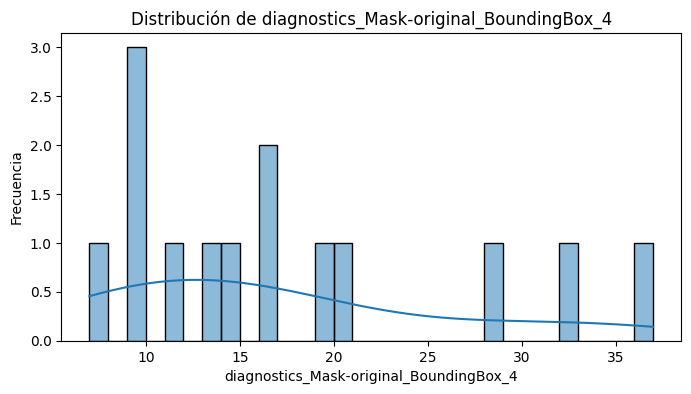

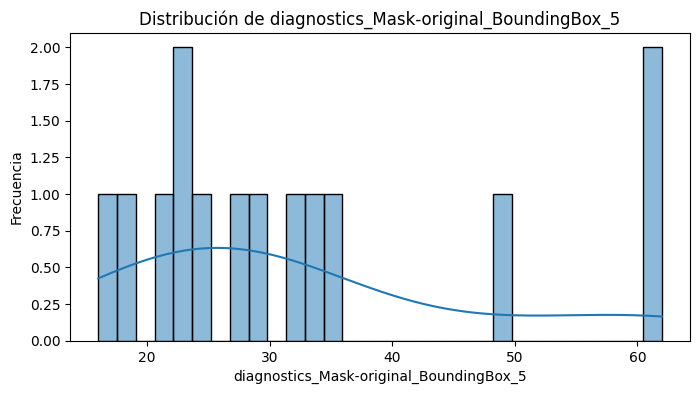

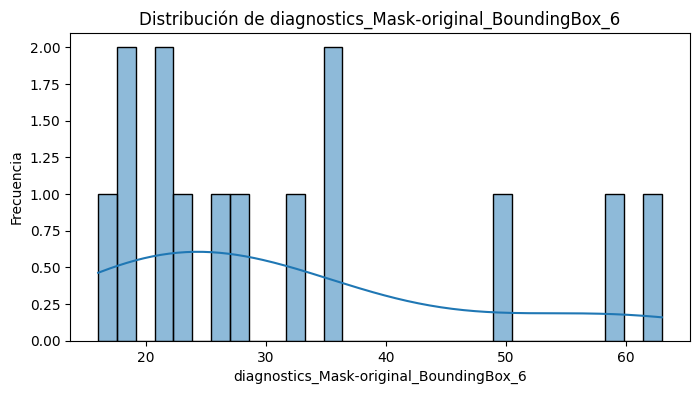

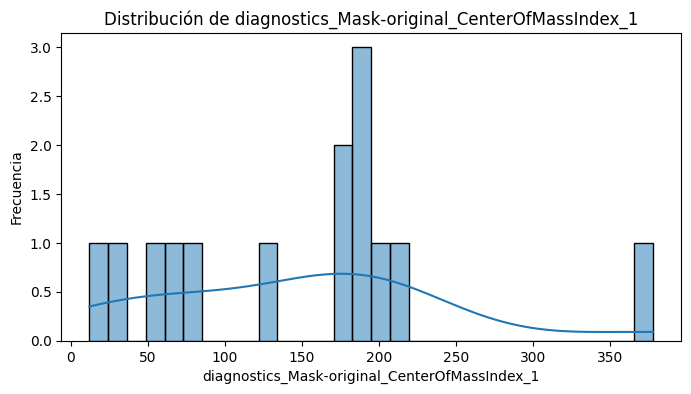

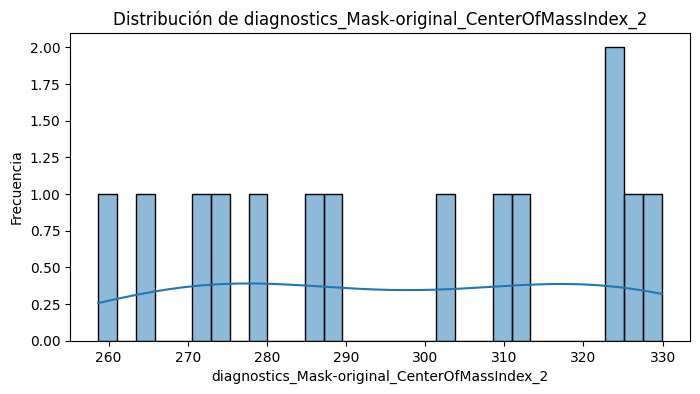

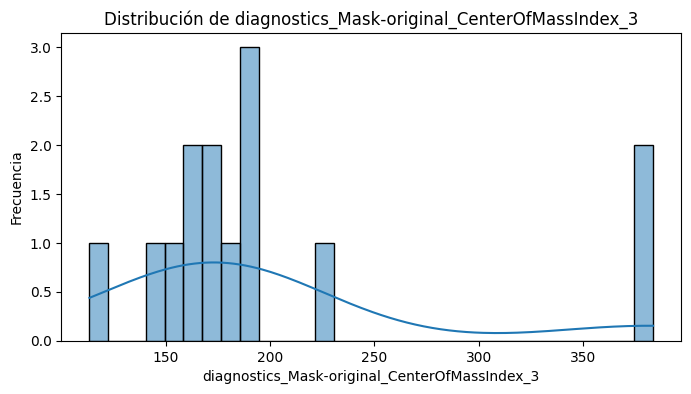

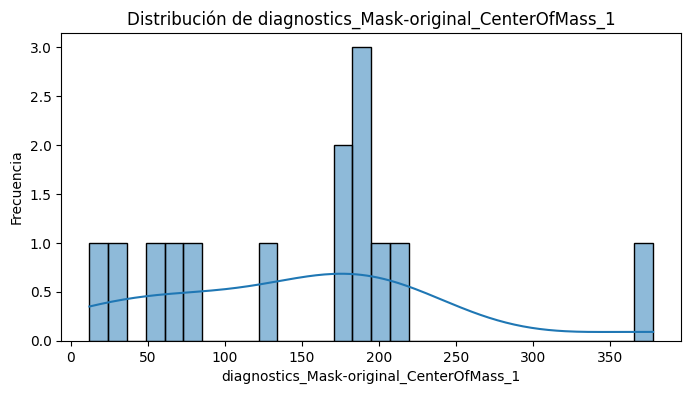

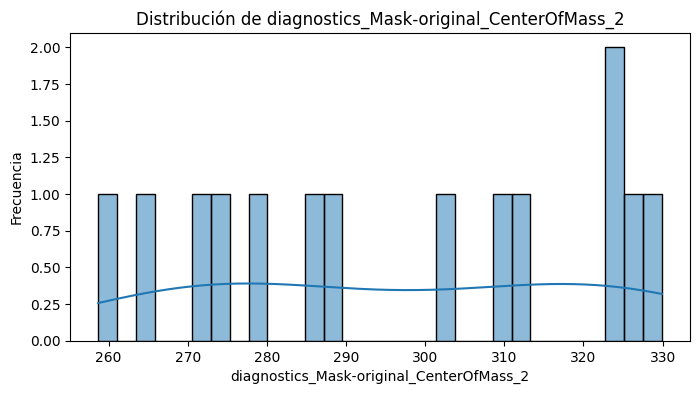

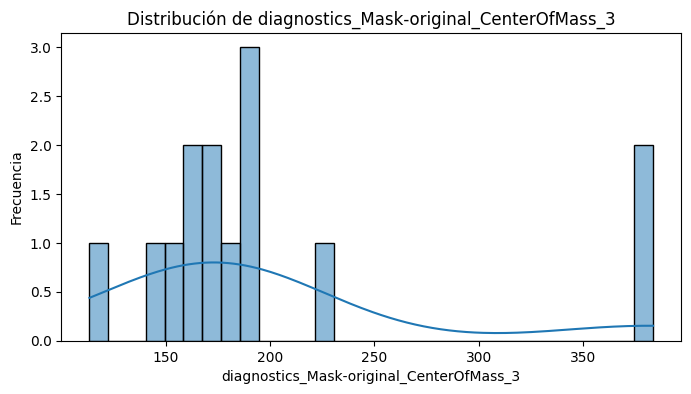

In [61]:
plot_variable_distribution(X)

                                                    Valores Faltantes  \
diagnostics_Image-original_Mean                                     0   
diagnostics_Image-original_Spacing_3                                0   
diagnostics_Image-original_Size_2                                   0   
diagnostics_Image-original_Size_3                                   0   
diagnostics_Mask-original_Spacing_1                                 0   
diagnostics_Mask-original_Spacing_2                                 0   
diagnostics_Mask-original_Spacing_3                                 0   
diagnostics_Mask-original_Size_1                                    0   
diagnostics_Mask-original_Size_2                                    0   
diagnostics_Mask-original_Size_3                                    0   
diagnostics_Mask-original_BoundingBox_1                             0   
diagnostics_Mask-original_BoundingBox_2                             0   
diagnostics_Mask-original_BoundingBox_3            

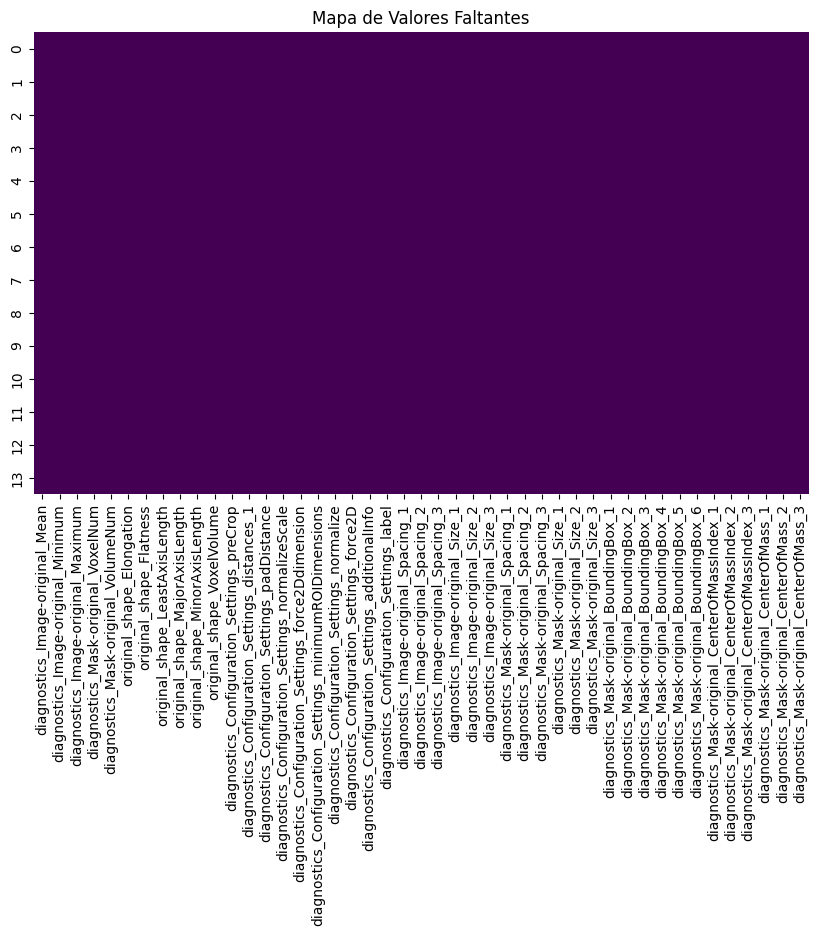

In [62]:
detect_missing_values(X)

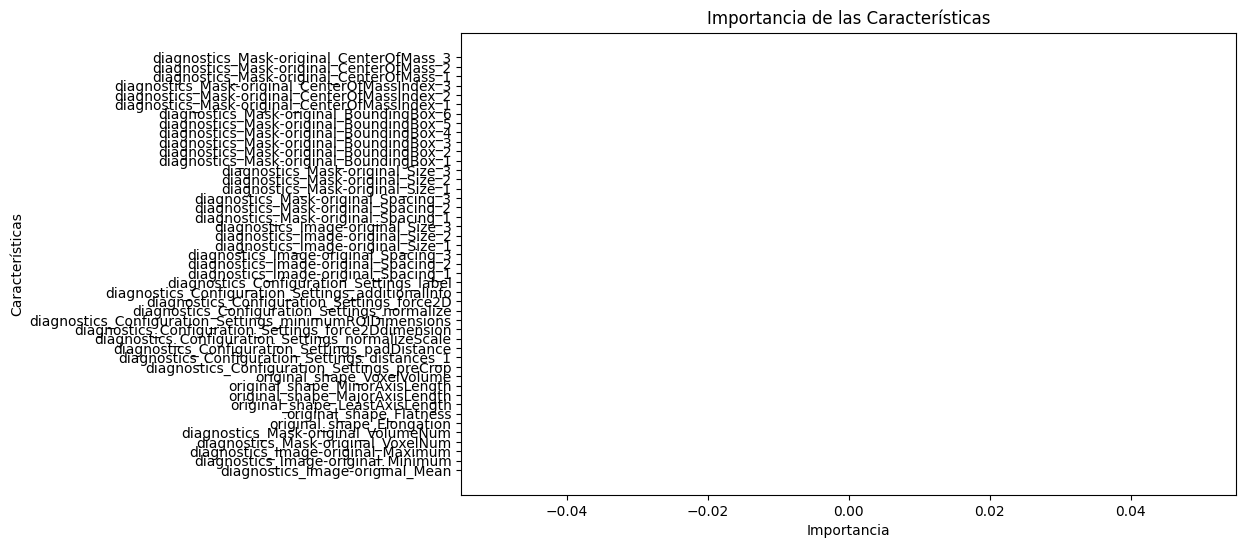

In [63]:
plot_feature_importance(X, y, features_names)

In [65]:
target_correlation_analysis(X, y)

KeyError: "None of [Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='int64')] are in the [columns]"

In [ ]:
calculate_vif(X)